In [1]:
import os
import torch
from torchaudio import transforms
import numpy as np
import pandas as pd
import random
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchaudio
torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False

np.random.seed(seed:=69)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
current_device = torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else 'cpu'
print(f'using device: {current_device}')

using device: GeForce GTX 1060 3GB


C:\ProgramData\Miniconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\ProgramData\Miniconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
input_path = './input/cleaned/'
output_path = './input/cleaned/output/'
sample_rate = 44100

In [3]:
input_li = pd.Series([input_path + 'x/' + i for i in os.listdir(input_path + 'x/')], dtype=str)
# targets have the exact same name, but are in the y/ folder, so to ensure that everything is in the 
# proper order, list through the input directory, but link to the y/ directory
target_li = pd.Series([input_path + 'y/' + i for i in os.listdir(input_path + 'x/')], dtype=str)
# table = pd.DataFrame(data=[X, y], columns=['input', 'target'])
# table.head()
df = pd.DataFrame(data={'input': input_li, 'target': target_li})
print(f'missing values: {df.isna().any().sum()}')
df.head()

missing values: 0


,input,target
0,./input/cleaned/x/12 Comics You Need to See - ...,./input/cleaned/y/12 Comics You Need to See - ...
1,./input/cleaned/x/12 Comics You Need to See - ...,./input/cleaned/y/12 Comics You Need to See - ...
2,./input/cleaned/x/12 Comics You Need to See - ...,./input/cleaned/y/12 Comics You Need to See - ...
3,./input/cleaned/x/12 Comics You Need to See - ...,./input/cleaned/y/12 Comics You Need to See - ...
4,./input/cleaned/x/12 Comics You Need to See - ...,./input/cleaned/y/12 Comics You Need to See - ...


In [4]:
class AudioDataset(Dataset):
    
    def __init__(self, input_path, transform=None):
        self.input_path = input_path
        # use a root path that branches into x/ and y/ directories
        input_li = pd.Series([input_path + 'x/' + i for i in os.listdir(input_path + 'x/')], dtype=str)
        # targets have the exact same name, but are in the y/ folder, so to ensure that everything is in the 
        # proper order, list through the input directory, but link to the y/ directory
        target_li = pd.Series([input_path + 'y/' + i for i in os.listdir(input_path + 'x/')], dtype=str)
        df = pd.DataFrame(data={'input': input_li, 'target': target_li})
        self.df = df.sample(frac=1, random_state=seed)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        x = self.df['input'].iloc[idx]
        x, _ = torchaudio.load(x)
        y = self.df['target'].iloc[idx]
        y, _ = torchaudio.load(y)
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y
    
    def random(self):
        idx = random.randint(0, len(self.df))
        return self.__getitem__(idx)

In [5]:
data = AudioDataset(input_path=input_path)
print(f'num samples: {len(data)}')
x, y = data[0]
x, y

num samples: 2144


(tensor([[ 0.1151,  0.1110,  0.1024,  ..., -0.2160, -0.2664, -0.3035],
         [ 0.0180,  0.0130,  0.0066,  ..., -0.1551, -0.1982, -0.2359]]),
 tensor([[ 0.0163,  0.0098,  0.0037,  ..., -0.1633, -0.1965, -0.2296],
         [-0.0075, -0.0092, -0.0106,  ..., -0.1255, -0.1577, -0.1906]]))

In [6]:
# loss function
def mse(output:torch.Tensor, label:torch.Tensor):
    return torch.mean((output - label) ** 2)

In [7]:
mse(x, y)

tensor(0.0043)

In [8]:
# build another loss function, which is based on:
# https://openaccess.thecvf.com/content_CVPR_2019/papers/Yuan_Signal-To-Noise_Ratio_A_Robust_Distance_Metric_for_Deep_Metric_Learning_CVPR_2019_paper.pdf
# tinyurl:
# https://tinyurl.com/yclop5na
# this is our implementation
class PSNR:
    """Peak Signal to Noise Ratio
    output and target have range [0, 255]"""

    def __init__(self):
        self.name = "PSNR"

    @staticmethod
    def __call__(output, target):
        mse = torch.mean((output - target) ** 2)
        return 20 * torch.log10(255.0 / torch.sqrt(mse))

class audio_PSNR:
    """Peak Signal to Noise Ratio
    output and target have range [-1, 1]"""

    def __init__(self):
        self.name = "audio PSNR"

    @staticmethod
    def __call__(output, target):
        mse = torch.mean((output - target) ** 2)
        return 20 * torch.log10(1.0 / torch.sqrt(mse))

In [9]:
class Model(nn.Module):
    
    def __init__(self):
        pass
    
    def melspectrogram(self, x):
        melspectrogram_transform = transforms.MelSpectrogram(
        sample_rate=44100, n_mels=128
        )
        melspectrogram_db_transform = transforms.AmplitudeToDB()
        

torch.Size([1, 1323000])


 ...]

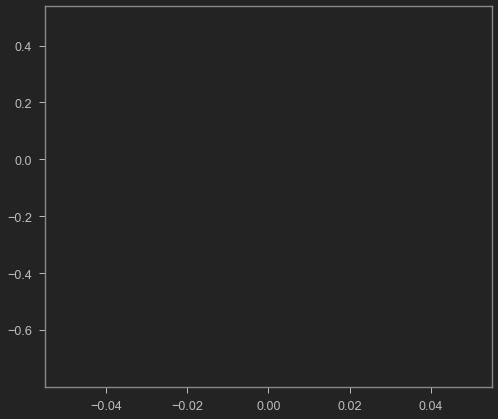

In [13]:
audio, truth = data.random()
audio = torch.mean(audio, dim=0, keepdim=True)
print(audio.shape)
plt.figure()
plt.plot(audio[:sample_rate * 5])

C:\ProgramData\Miniconda3\lib\site-packages\torchaudio\functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
C:\ProgramData\Miniconda3\lib\site-packages\torch\functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
C:\ProgramData\Miniconda3\lib\site-packages\torch\functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered 

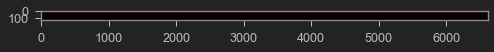

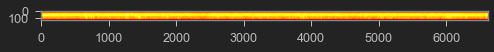

In [12]:
melspectogram_transform = \
    torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate, n_mels=128)
melspectogram_db_transform = torchaudio.transforms.AmplitudeToDB()

melspectogram = melspectogram_transform(audio)
plt.figure()
plt.imshow(melspectogram.squeeze().numpy(), cmap='hot')
    
melspectogram_db=melspectogram_db_transform(melspectogram)
plt.figure()
plt.imshow(melspectogram_db.squeeze().numpy(), cmap='hot')